In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from agent import Agent
from torchsummary import summary
import time
plt.ion()

In [2]:
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [6]:
# env.close()

In [7]:
seed = 42

# Create agent
agent = Agent(state_size=state_size, action_size=action_size, n_agents=num_agents, seed=seed)

In [9]:
def ddpg(max_episodes=2000, max_timesteps = 1000):

    scores_deque = deque(maxlen=100) 
    scores = []        
    best_average_score = -np.inf

    for i_episode in range(1, max_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        agent.reset()
        episode_scores = np.zeros(num_agents) 

        for t in range(max_timesteps):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent.step(states=states, actions=actions, rewards=rewards, next_states=next_states, dones=dones, timestep=t)
            episode_scores += np.array(rewards)
            states = next_states
            if np.any(dones):
                break

        episode_score = np.mean(episode_scores) # Summary of scores for this episode
        scores_deque.append(episode_score)
        scores.append(episode_score)
        average_score = np.mean(scores_deque)

        print(f'\rEpisode: {i_episode}\tAverage Score: {average_score}\tCurrent Score: {episode_score}', end="")
        if i_episode % 10 == 0:
            print(f'\rEpisode: {i_episode}\tAverage Score: {average_score}\tCurrent Score: {episode_score}')

        if average_score >= 30.0:
            print('\nEnvironment solved in {i_episode} episodes!\tAverage Score: {average_score}')
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

    return scores

In [10]:
scores = ddpg()


Episode: 10	Average Score: 0.24374999455176294	Current Score: 0.35999999195337296
Episode: 20	Average Score: 0.3005749932816252	Current Score: 0.14649999672546982
Episode: 30	Average Score: 0.38973332462211446	Current Score: 0.9769999781623483
Episode: 40	Average Score: 0.6308499858994037	Current Score: 1.2794999714009463
Episode: 50	Average Score: 0.8424199811704457	Current Score: 1.9889999555423856
Episode: 60	Average Score: 1.046099976617843	Current Score: 2.6869999399408697
Episode: 70	Average Score: 1.2751856857830923	Current Score: 2.8169999370351433
Episode: 80	Average Score: 1.5210374660021624	Current Score: 3.6059999193996193
Episode: 90	Average Score: 1.7640666272367038	Current Score: 4.1889999063685535
Episode: 100	Average Score: 2.0231999547779562	Current Score: 4.301999903842807
Episode: 110	Average Score: 2.509314943912439	Current Score: 5.869499868806452
Episode: 120	Average Score: 2.97817993343249	Current Score: 4.6789998954162
Episode: 130	Average Score: 3.536859920945

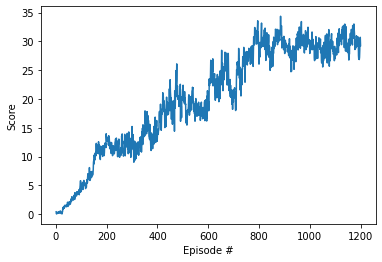

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()